In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
from astropy.io import fits
import fitsio
from scipy import stats

import sys, os, warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, KFold

# Load and Prepare Data

In [2]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/spectro/redux/daily/exposures-daily.fits'))
mask = cat['SURVEY']=='main'
mask &= cat['PROGRAM']=='bright'
mask &= cat['EFFTIME_ETC']>100
mask &= cat['EFFTIME_SPEC']>100
mask &= cat['MJD'] != 0
cat = cat[mask]
cat

NIGHT,EXPID,TILEID,TILERA,TILEDEC,MJD,SURVEY,PROGRAM,FAPRGRM,FAFLAVOR,EXPTIME,EFFTIME_SPEC,GOALTIME,GOALTYPE,MINTFRAC,AIRMASS,EBV,SEEING_ETC,EFFTIME_ETC,TSNR2_ELG,TSNR2_QSO,TSNR2_LRG,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBDARK,TSNR2_GPBBRIGHT,TSNR2_GPBBACKUP,LRG_EFFTIME_DARK,ELG_EFFTIME_DARK,BGS_EFFTIME_BRIGHT,LYA_EFFTIME_DARK,GPB_EFFTIME_DARK,GPB_EFFTIME_BRIGHT,GPB_EFFTIME_BACKUP,TRANSPARENCY_GFA,SEEING_GFA,FIBER_FRACFLUX_GFA,FIBER_FRACFLUX_ELG_GFA,FIBER_FRACFLUX_BGS_GFA,FIBERFAC_GFA,FIBERFAC_ELG_GFA,FIBERFAC_BGS_GFA,AIRMASS_GFA,SKY_MAG_AB_GFA,SKY_MAG_G_SPEC,SKY_MAG_R_SPEC,SKY_MAG_Z_SPEC,EFFTIME_GFA,EFFTIME_DARK_GFA,EFFTIME_BRIGHT_GFA,EFFTIME_BACKUP_GFA
int32,int32,int32,float64,float64,float64,str7,str6,str19,str19,float64,float64,float64,str7,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
20210515,88523,20274,177.311,-5.36,59350.136565,main,bright,bright,mainbright,1029.203857421875,111.46702758789064,180.0,bright,0.85,1.2635430097579956,0.034049488604068756,1.3169820308685303,181.2156982421875,11.737977027893066,2.947366714477539,7.64034366607666,11.902766386698932,796.1930541992188,0.0,0.0,0.0,92.83480347657645,100.94660243988041,111.46702758789064,136.1647673573828,0.0,0.0,0.0,1.0290300908924668,1.8689600028695508,0.29501223490780326,0.24333622104564745,0.1201011655205835,0.5053269653297021,0.5699508276361451,0.6120775108822101,1.2602103894499523,20.397204702433392,20.314024920314115,20.441895459877845,19.06040464161056,210.34287533291783,170.25640116375763,210.34287533291783,163.4793786227367
20210515,88530,21161,206.176,35.08,59350.2311143,main,bright,bright,mainbright,344.0836181640625,222.15159667968751,180.0,bright,0.85,1.0014950037002563,0.017907753586769104,1.1702309846878052,185.8169708251953,24.43427276611328,5.983607292175293,16.772539138793945,14.469748517824337,1586.797119140625,0.0,0.0,0.0,203.79651005315128,210.1347457885743,222.15159667968751,165.53042180606997,0.0,0.0,0.0,1.1285904113476672,1.2990799260065407,0.44299874672605455,0.3316965719712242,0.1559932186773495,0.839030297009578,0.8576763517717917,0.8717685888705631,1.0014908822499025,21.48542766512692,22.257411470557358,21.53152645573922,19.417987502971105,225.52440278898348,213.32310677505154,225.52440278898348,216.65202061519454
20210515,88534,20776,231.975,36.497,59350.30633578,main,bright,bright,mainbright,379.1694641113281,226.42063964843751,180.0,bright,0.85,1.0032269954681396,0.020433980971574783,1.3338799476623535,181.425537109375,25.333065032958984,6.147915363311768,17.265979766845703,13.750215971376747,1617.290283203125,0.0,0.0,0.0,209.79211257243773,217.86435928344736,226.42063964843751,157.29914357964134,0.0,0.0,0.0,1.0445319716165968,1.3044149209236984,0.4397740093023417,0.3305328028096365,0.15567710116400413,0.7513128168058492,0.7721516661811704,0.7894629480460515,1.0034496575526717,21.54592007435791,22.430924471511236,21.562861339540262,19.319533641627416,211.81557398669173,201.05028797891106,211.81557398669173,194.29307471684143
20210515,88545,20914,264.913,31.555,59350.43733847,main,bright,bright,mainbright,298.2001037597656,250.40782470703127,180.0,bright,0.85,1.0262880325317383,0.05436989665031433,0.9463080167770386,186.7118682861328,27.721927642822266,6.774373531341553,18.953174591064453,13.507910874811932,1788.6273193359375,0.0,0.0,0.0,230.29255165981647,238.40857772827158,250.40782470703127,154.52723190538336,0.0,0.0,0.0,1.0124586827301965,0.9936094911666413,0.6083452881566576,0.4350896648828896,0.1989847405554178,1.0281550074729973,1.0091467227164892,1.0025670822594654,1.0284792834355638,21.922117278562656,22.400489451728465,21.571447019914483,19.673688268195264,212.2111770504912,206.94435780339856,212.2111770504912,237.50286349527525
20210515,88548,20888,271.59,30.864,59350.46949101,main,bri

In [3]:
# Select the specific columns we want
'''
INCLUDE:
Airmass
EBV
transparency
seeing
fiber-fracflux gfa
skymag all include g-r
efftime ga

'''
X = np.column_stack([
cat['AIRMASS'],
cat['EBV'],
cat['TRANSPARENCY_GFA'],
cat['SEEING_GFA'],
cat['FIBER_FRACFLUX_GFA'],
cat['SKY_MAG_AB_GFA'],
cat['SKY_MAG_G_SPEC'],
cat['SKY_MAG_R_SPEC'],
cat['SKY_MAG_G_SPEC']-cat['SKY_MAG_R_SPEC'],
cat['SKY_MAG_Z_SPEC'],
cat['EFFTIME_GFA'],
])
y = np.column_stack([cat['EFFTIME_SPEC']/cat['EFFTIME_ETC']])
y = np.ravel(y)

# Train the Random Forest Regressor

### Split the data 50/50 train/test

In [4]:
# Split the training and testing set 50/50
idx_train, idx_test = train_test_split(np.arange(len(cat)), test_size=0.5, random_state=6123)

# Train the random forest
regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
regrf.fit(X[idx_train], y[idx_train])

RandomForestRegressor(max_depth=50, n_estimators=50, n_jobs=4,
                      random_state=1456)

### Feature Importances

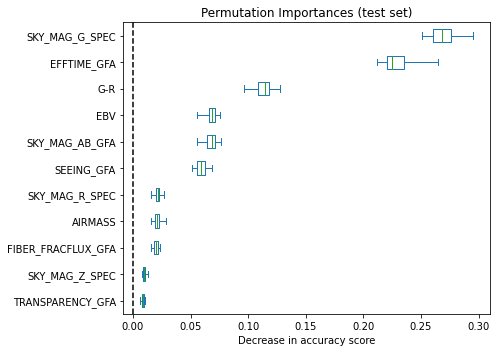

In [5]:
from sklearn.inspection import permutation_importance
import pandas as pd

data = pd.DataFrame(columns=['AIRMASS','EBV', 'TRANSPARENCY_GFA', 'SEEING_GFA', 'FIBER_FRACFLUX_GFA', 'SKY_MAG_AB_GFA','SKY_MAG_G_SPEC','SKY_MAG_R_SPEC','G-R','SKY_MAG_Z_SPEC','EFFTIME_GFA'])

result = permutation_importance(
    regrf, X[idx_test], y[idx_test], n_repeats=50, random_state=42, n_jobs=2
)
sorted_importances_idx = result.importances_mean.argsort()
sorted_importances_idx = sorted_importances_idx.astype(int),

importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=data.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10,figsize=(7,5))
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()



NMAD = 0.07218
Outlier fraction = 20.87%


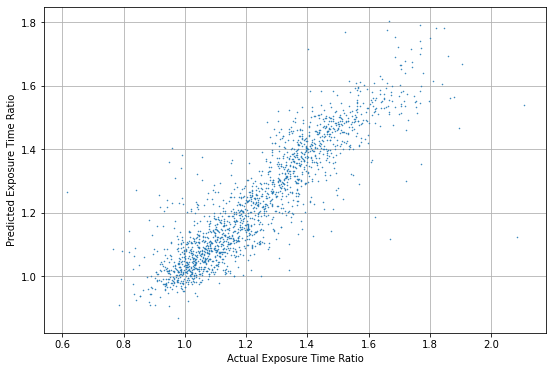

In [6]:
etratio_pred = regrf.predict(X[idx_test])
etratio_actu = y[idx_test]

nmad = 1.48 * np.median(np.abs((etratio_pred - etratio_actu)))
outlier_threshold = 0.1
outlier_frac = np.sum(np.abs((etratio_pred - etratio_actu)) > outlier_threshold)/len(etratio_actu)
print('NMAD = {:.5f}'.format(nmad))
print('Outlier fraction = {:.2f}%'.format(outlier_frac*100))

plt.figure(figsize=(9, 6))
plt.plot(etratio_actu, etratio_pred, '.', markersize=1)
plt.xlabel('Actual Exposure Time Ratio')
plt.ylabel('Predicted Exposure Time Ratio')
#plt.axis([0.6, 1.8, 0.8, 1.5])
plt.grid()
plt.show()

### 5 Fold Cross Validation

In [7]:
n_folds = 5
#kf createst the folds
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1456)
np.random.seed(123)
etratio_pred = np.zeros(len(cat))

for kf_index, (idx_train, idx_test) in enumerate(kf.split(X)):
# there's a different idx_train and idx_test for each fold
    print('Fold %d'%(kf_index+1))
    regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
    regrf.fit(X[idx_train], y[idx_train])
    etratio_pred[idx_test] = regrf.predict(X[idx_test])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


NMAD = 0.06860
Outlier fraction = 18.40%


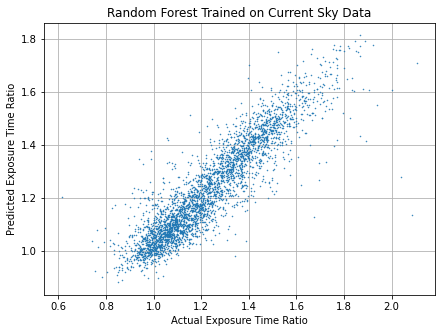

In [8]:
etratio_actu = y

nmad = 1.48 * np.median(np.abs((etratio_pred - etratio_actu)))
outlier_threshold = 0.1
outlier_frac = np.sum(np.abs((etratio_pred - etratio_actu)) > outlier_threshold)/len(etratio_actu)
print('NMAD = {:.5f}'.format(nmad))
print('Outlier fraction = {:.2f}%'.format(outlier_frac*100))

plt.figure(figsize=(7, 5))
plt.plot(etratio_actu, etratio_pred, '.', markersize=1)
plt.title('Random Forest Trained on Current Sky Data')
plt.xlabel('Actual Exposure Time Ratio')
plt.ylabel('Predicted Exposure Time Ratio')
#plt.axis([0.6, 1.8, 0.8, 1.5])
plt.grid()
plt.show()

# Optimize Random Forest Corrections

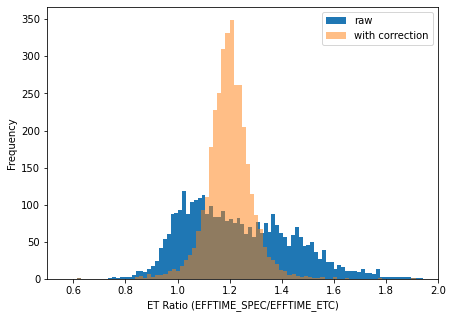

1.2328394194441152

In [13]:
etratio_actu = y
cor_etratio = etratio_actu/etratio_pred

plt.figure(figsize=(7, 5))

plt.hist(etratio_actu,bins = 100);
plt.hist(cor_etratio*1.2,bins = 100, alpha = 0.5);
plt.legend(['raw', 'with correction'])
plt.xlim(0.5, 2.0)


plt.xlabel('ET Ratio (EFFTIME_SPEC/EFFTIME_ETC)')
plt.ylabel('Frequency')

plt.show()

In [10]:
# function that counts the number of data points outside the 0.85-1.15 range in arr
def count_highs(arr):
    return (np.array(arr) > 1.15).sum()/len(arr)

def count_lows(arr):
    return (np.array(arr) < 0.85).sum()/len(arr)

In [11]:

# function that counts the number of data points outside the 0.85-1.15 range in arr
def count_highs(arr):
    return (np.array(arr) > 1.15).sum()/len(arr)

def count_lows(arr):
    return (np.array(arr) < 0.85).sum()/len(arr)

def show_stats(arr, name): # takes in the array and the name of the data
    print('Statistics for', name)
    print('Fraction under 0.85:', count_lows(arr))
    print('Fraction over 1.15:', count_highs(arr))
    print('Median Absolute Deviation:', stats.median_abs_deviation(arr))
    print('Standard Deviation:', np.std(arr))
    print('-------------------------------')
    outliersraw = count_lows(etratio_actu)+count_highs(etratio_actu)
    outliersarr = count_lows(arr) + count_highs(arr)
    print('Outlier %: ', outliersarr*100, '%')
    print('Underexposed < 0.85: ', count_lows(arr)*100, '%')
    print('Reduction in outliers from Raw Data:', outliersraw - outliersarr, "(", (outliersraw-outliersarr)/outliersraw*100,"% less than raw)")
    print('Reduction in MAD from Raw Data:', stats.median_abs_deviation(etratio_actu) - stats.median_abs_deviation(arr), "(", (stats.median_abs_deviation(etratio_actu) - stats.median_abs_deviation(arr))/stats.median_abs_deviation(etratio_actu) *100,"% less than raw)")
    print('Reduction in SD from Raw Data:', np.std(etratio_actu) - np.std(arr), "(", (np.std(etratio_actu) - np.std(arr))/np.std(etratio_actu) *100,"% less than raw)")

    print('-------------------------------')


In [40]:
show_stats(etratio_actu, "Raw Data")
print()
show_stats(etratio_actu/etratio_pred, "Unlimited Correction Data")
print()


Statistics for Raw Data
Fraction under 0.85: 0.00641399416909621
Fraction over 1.15: 0.5854227405247814
Median Absolute Deviation: 0.1547347420255859
Standard Deviation: 0.20981569998368585
-------------------------------
Outlier %:  59.183673469387756 %
Underexposed < 0.85:  0.641399416909621 %
Reduction in outliers from Raw Data: 0.0 ( 0.0 % less than raw)
Reduction in MAD from Raw Data: 0.0 ( 0.0 % less than raw)
Reduction in SD from Raw Data: 0.0 ( 0.0 % less than raw)
-------------------------------

Statistics for Unlimited Correction Data
Fraction under 0.85: 0.02361516034985423
Fraction over 1.15: 0.02099125364431487
Median Absolute Deviation: 0.03838559980652406
Standard Deviation: 0.07240223712699008
-------------------------------
Outlier %:  4.46064139941691 %
Underexposed < 0.85:  2.361516034985423 %
Reduction in outliers from Raw Data: 0.5472303206997085 ( 92.46305418719211 % less than raw)
Reduction in MAD from Raw Data: 0.11634914221906184 ( 75.19264303282525 % less tha